# About the data 

This noteook include train and original dataset both.
Both datasets include the categorical target variable 'WeightCategory'. This variable denotes the deduced obesity level for a given individual. The levels of the target variable include:

* Insufficient_Weight
* Normal_Weight
* Overweight_Level_I
* Overweight_Level_II
* Obesity_Type_I
* Obesity_Type_II
* Obesity_Type_III

Both datasets also include 16 predictors, some of which are categorical and others are numerical. These predictors include:
* Gender
* Age
* Height
* Weight
* family_history_with_overweight (yes/no)
* FAVC (frequent consumption of high caloric food, yes/no)
* FCVC (frequency of consumption of vegetables)
* NCP (number of main meals)
* CAEC (consumption of food between meals)
* SMOKE (smoker or not, yes/no)
* CH20 (consumption of water daily)
* SCC (monitoring consumption of calories, yes/no)
* FAF (physical activity frequency)
* TUE (time using technology devices)
* CALC (consumption of alcohol)
* MTRANS (transportation used)
The Kaggle dataset includes a 18th column, which provides an 'id' key. This column is mostly used for submission purposes.

# Importing the libraries

In [96]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import optuna
from optuna.samplers import TPESampler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance

pd.set_option('display.max_rows',150)
pd.set_option('display.max_columns',600)

sns.set(style='whitegrid')
from sklearn.model_selection import cross_val_score
import optuna
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from category_encoders import MEstimateEncoder

# Reading the data

In [97]:
train_data = pd.read_csv('../data/train.csv')

train_data.name = "Train Dataset"
test_data = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

original_data = pd.read_csv('../data/ObesityDataSet.csv')
original_data.name = "Original Dataset"


print("# Train Data INFO\n")
print(train_data.info())
print('='*50)
print("\n# Original Data INFO\n")
print(original_data.info())

# Train Data INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15533 entries, 0 to 15532
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15533 non-null  int64  
 1   Gender                          15533 non-null  object 
 2   Age                             15533 non-null  float64
 3   Height                          15533 non-null  float64
 4   Weight                          15533 non-null  float64
 5   family_history_with_overweight  15533 non-null  object 
 6   FAVC                            15533 non-null  object 
 7   FCVC                            15533 non-null  float64
 8   NCP                             15533 non-null  float64
 9   CAEC                            15533 non-null  object 
 10  SMOKE                           15533 non-null  object 
 11  CH2O                            15533 non-null  float64
 12  SCC          

In [98]:
train_data.shape

(15533, 18)

In [99]:

print(train_data.shape)
train_data.head()



(15533, 18)


id  Gender        Age    Height      Weight family_history_with_overweight  \
0   0    Male  24.443011  1.699998   81.669950                            yes   
1   1  Female  18.000000  1.560000   57.000000                            yes   
2   2  Female  18.000000  1.711460   50.165754                            yes   
3   3  Female  20.952737  1.710730  131.274851                            yes   
4   4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC                 MTRANS       WeightCategory  
0  0.976473  Sometimes  Public_Transportation  Overweight_Level_II  
1  1.000000         no             Automobile        Normal_Weight  
2  1.673584         no  Public_Transportation  Insufficient_Weight  
3  0.780199  Sometimes  Public_Transportation     Obesity_Type_III  
4  0.931721  Sometimes  Public_Transportation  Overweight_Level_II

In [100]:
train_data.describe().T.style.background_gradient()

Here, we can obtain some basic summary statistics of the train dataset. In the 'count' row, we can verify that each column contains 15533 entries of data. This provides evidence that there is no missing data in this dataset. In the following rows, we obtain further useful information, such as the mean values, standard deviation, minimum and maximum values, and quartiles. At a glance, the minimum and maximum values can help us identify any potential anomalies. For example, if the maximum value of the 'Age' column was 1546, we could deduce that this value is incorrect and likely an error. Fortunately, the minimum and maximum values for 'Age' are 14 and 61, respectively. This provides further evidence of the cleanliness and accuracy of the dataset.

There are more summary statistics of the train dataset. To start, we can confirm the datatype of each column. At a glance, many of the column datatypes are numerical and are either int64 or float64. The remaining columns are categorical predictors and are object datatypes. It is important to take note of this, as all columns with object datatypes will need to be converted into boolean values using one-hot encoding. This will be done in the Data Preprocessing section of this project. It is imperative to convert these datatypes, as objects with values such as 'Yes' or 'No' will need to be transformed into boolean values, such as '0' or '1', so that the model can leverage these categorical predictors.

The code chunk above also shows us if there are any null values in the dataset. Fortunately, this dataset has already been cleaned and thus contains no null values.

In [101]:
test_data.head()


id  Gender        Age    Height      Weight  \
0  15533  Female  19.007177  1.772449  137.852618   
1  15534  Female  21.572114  1.698346   75.000000   
2  15535    Male  22.285024  1.737453   82.000000   
3  15536    Male  30.916426  1.775580  120.860386   
4  15537  Female  18.000000  1.670000   65.000000   

  family_history_with_overweight FAVC      FCVC       NCP       CAEC SMOKE  \
0                            yes  yes  3.000000  3.000000  Sometimes    no   
1                            yes  yes  2.000000  3.000000  Sometimes    no   
2                            yes  yes  2.000000  2.720642  Sometimes    no   
3                            yes  yes  2.712747  3.000000  Sometimes    no   
4                             no  yes  2.000000  3.000000  Sometimes    no   

       CH2O SCC       FAF       TUE       CALC                 MTRANS  
0  2.007348  no  1.465931  0.813235  Sometimes  Public_Transportation  
1  2.000000  no  1.577824  1.865851  Sometimes  Public_Transportation  
2  1.830614  no  0.451009  0.000000  Sometimes  Public_Transportation  
3  2.144368  no  0.712726  0.100048  Sometimes             Automobile  
4  2.000000  no  1.000000  1.000000         no  Public_Transportation

In [102]:
test_data.describe().T.style.background_gradient()


In [103]:
original_data.rename(columns={'NObeyesdad': 'WeightCategory'}, inplace=True)
original_data.head()



Gender        Age    Height      Weight family_history_with_overweight FAVC  \
0   Male  21.708354  1.722396   94.790579                            yes  yes   
1   Male  21.000000  1.780000   72.000000                            yes  yes   
2   Male  31.190219  1.838441   92.062610                            yes  yes   
3   Male  18.000000  1.792239  108.602715                            yes  yes   
4   Male  33.000000  1.700000   85.000000                            yes  yes   

   FCVC       NCP       CAEC SMOKE      CH2O SCC       FAF       TUE  \
0   2.0  1.000000  Sometimes    no  2.708168  no  2.627515  0.000000   
1   3.0  3.000000  Sometimes    no  3.000000  no  2.000000  0.000000   
2   2.0  1.468948  Sometimes    no  1.507638  no  0.000000  0.975504   
3   2.0  1.120102  Sometimes    no  2.622638  no  1.000000  1.343044   
4   2.0  3.000000  Sometimes    no  2.000000  no  1.000000  0.000000   

         CALC                 MTRANS       WeightCategory  
0  Frequently  Public_Transportation       Obesity_Type_I  
1   Sometimes  Public_Transportation        Normal_Weight  
2   Sometimes  Public_Transportation  Overweight_Level_II  
3          no  Public_Transportation       Obesity_Type_I  
4   Sometimes             Automobile  Overweight_Level_II

In [104]:
original_data.describe().T.style.background_gradient()


Again, the two code chunks above provide us with some basic statistical information of the original dataset. As with the train dataset, this dataset also appears to have clean and accurate data. The only significant difference between the original and train datasets is that the original dataset has far fewer rows of data.

Above, we can see the shapes (or dimensions) of the datasets used in this project. To start, the shape of the train dataset is (15533, 18), meaning that there are 15533 entries (or rows) of data and 18 attributes (or columns). As mentioned above, these columns include the target variable, 16 predictors, and the 'id' column. The test data has a similar shape of (5225, 17). Here, we can see that the test dataset includes ~66% of the number of entries as the train dataset. Furthermore, the test dataset only includes 17 columns, as the target variable column has been omitted. Lastly, the shape of the original dataset is (2111, 17). This dataset is obviously much smaller than the train dataset, as it has far fewer entries of data. Furthermore, the original dataset only includes 17 columns, as it does not include the 'id' column. Despite its small size, the original dataset remains useful, as we can combine it with the train dataset to provide our model with more training data.

# EDA

## Outlier Detection

In [105]:

# Copy to avoid changing the original dataframe accidentally
df_features = test_data.copy()

# Select numeric columns
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()

# Detect and skip binary (one-hot) columns (only values {0,1} or {0.0,1.0})
def is_binary_series(s):
    vals = s.dropna().unique()
    vals_rounded = set(np.round(vals, 6))
    return vals_rounded.issubset({0, 1})

numeric_nonbinary = [c for c in numeric_cols if not is_binary_series(df_features[c])]

report = []
for col in numeric_nonbinary:
    series = df_features[col].dropna()
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Count how many values are outside fences
    below = (df_features[col] < lower).sum()
    above = (df_features[col] > upper).sum()

    # Winsorize (cap) outliers instead of removing them
    df_features[col] = df_features[col].clip(lower=lower, upper=upper)

    report.append((col, int(below), int(above), float(lower), float(upper)))

print("IQR Winsorization report (skipped binary one-hot columns):")
print("{:40s} {:>8s} {:>8s} {:>12s} {:>12s}".format("column", "below", "above", "lower", "upper"))
for col, below, above, lower, upper in report:
    print(f"{col:40s} {below:8d} {above:8d} {lower:12.4g} {upper:12.4g}")

# Replace test_data with the winsorized version for further processing
test_data = df_features.copy()

IQR Winsorization report (skipped binary one-hot columns):
column                                      below    above        lower        upper
id                                              0        0    1.292e+04    2.337e+04
Age                                             0      282           11           35
Height                                          0        0         1.44        1.954
Weight                                          0        0        -1.33        179.6
FCVC                                            0        0          0.5          4.5
NCP                                          1179      325            3            3
CH2O                                            0        0       0.6249        3.721
FAF                                             0        0       -2.398        4.039
TUE                                             0        0         -1.5          2.5


## Categorical predictors
This section aims to visualize the distributions of the eight categorical predictors and the single target variable in the train dataset by using donut charts and bar charts with count values. The categorical predictors and target variable include:

WeightCategory
Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS

In [106]:
def get_variable_types(dataframe):
    continuous_vars = []
    categorical_vars = []

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':
            categorical_vars.append(column)
        else:
            continuous_vars.append(column)

    return continuous_vars, categorical_vars

continuous_vars, categorical_vars = get_variable_types(train_data)
continuous_vars.remove('id'), categorical_vars.remove('WeightCategory')

print("Continuous Variables:", continuous_vars)
print("Categorical Variables:", categorical_vars)

Continuous Variables: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical Variables: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [107]:
def plot_distribution(dataframe, target_column):
    value_counts = dataframe[target_column].value_counts()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis", ax=ax1)
    ax1.set_xlabel(target_column, fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)

    for index, value in enumerate(value_counts):
        ax1.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

    ax2.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(value_counts)))
    ax2.axis('equal')

    # Main title for the figure
    fig.suptitle(f'Comparison of {target_column} Distribution in ({dataframe.name})', fontsize=18)
    
    plt.tight_layout()
    plt.show()

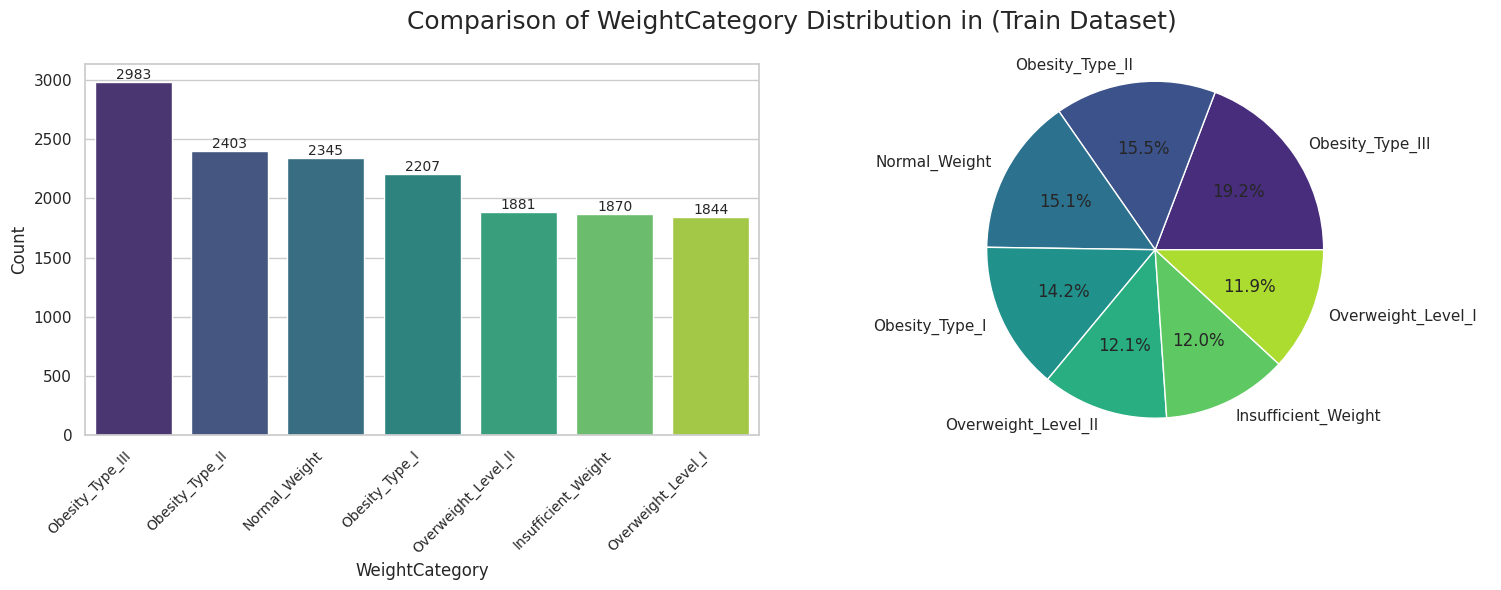

In [108]:
train_data.name = "Train Dataset"

plot_distribution(train_data,'WeightCategory')


Above, we can see the distribution of classes for the target variable 'WeightCategory'. This variable has seven different classes, which correspond to an individual's obesity status. At a glance, there appears to be a roughly even distribution of classes. Shockingly, only 15.1% of individuals taking the survey were of normal weight and only 12% were underweight ('Insufficient_Weight'). This means that the vast majority (73%) of individuals were AT LEAST overweight ('Overweight_Level_I'). Moreover, almost half (49.1%) of the survey population had some type of obesity.

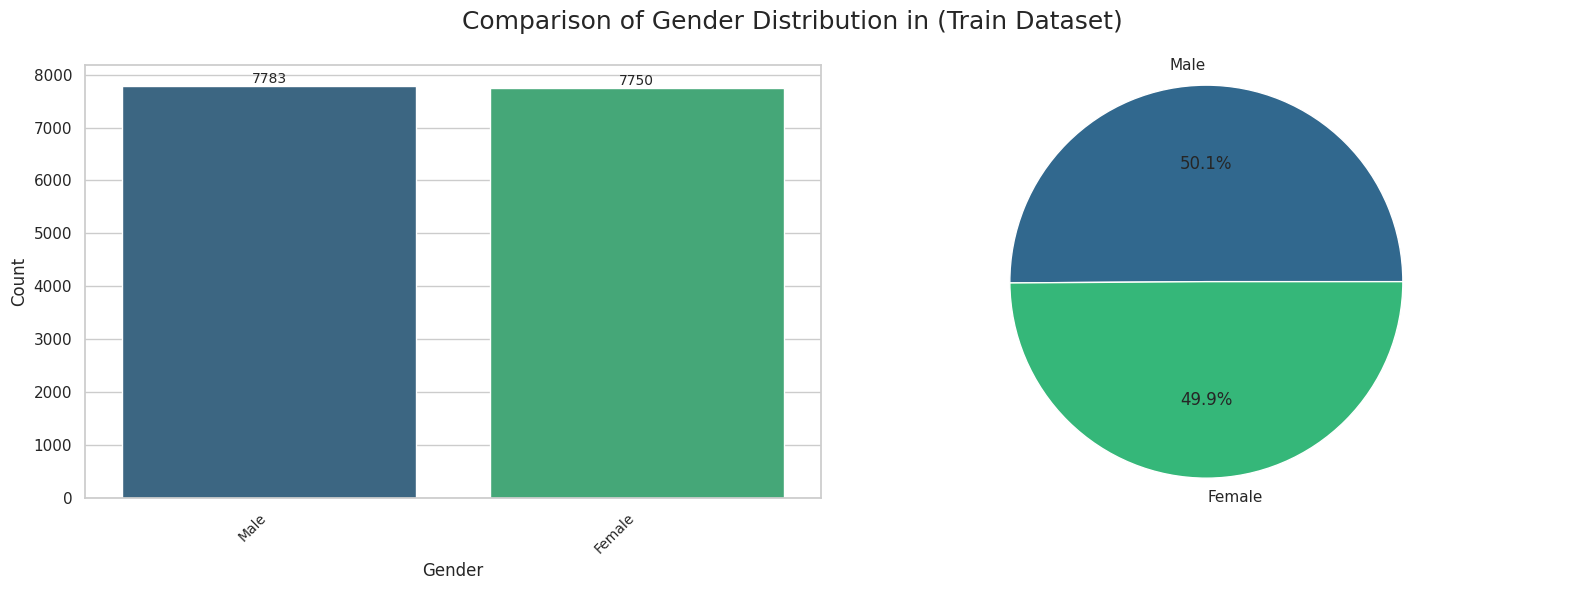

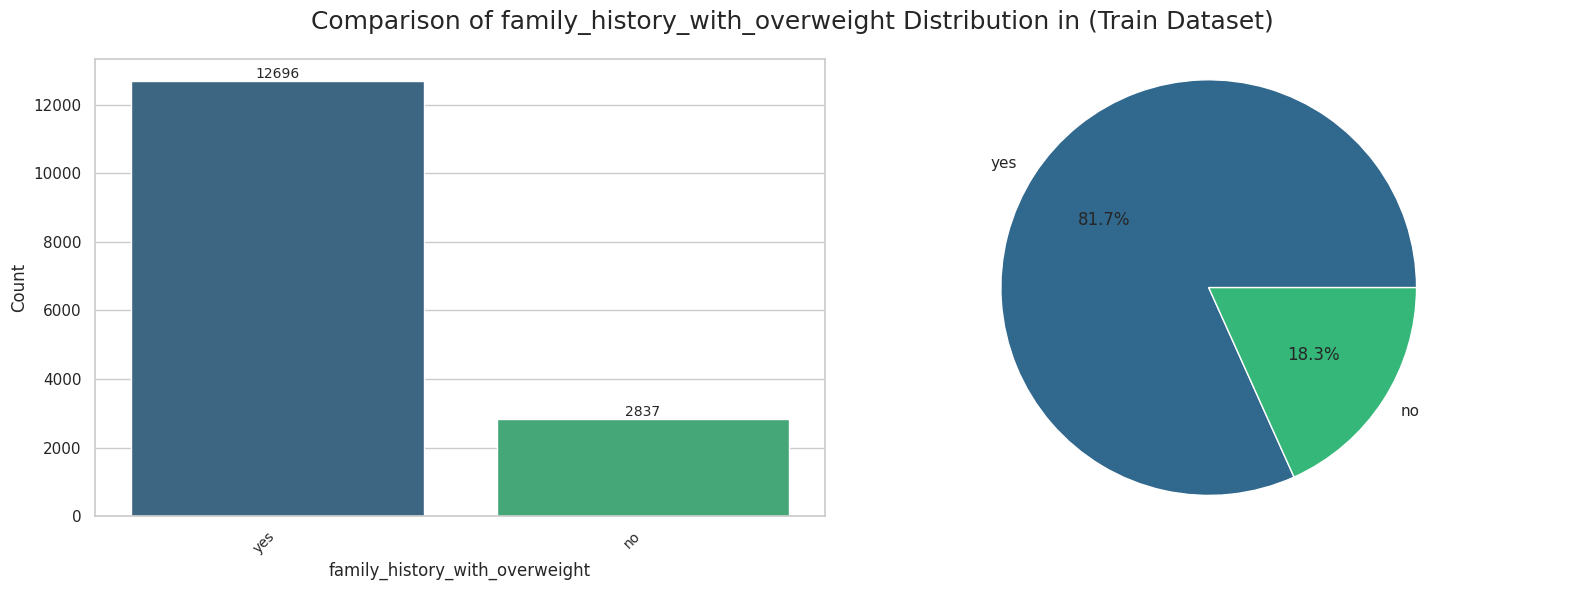

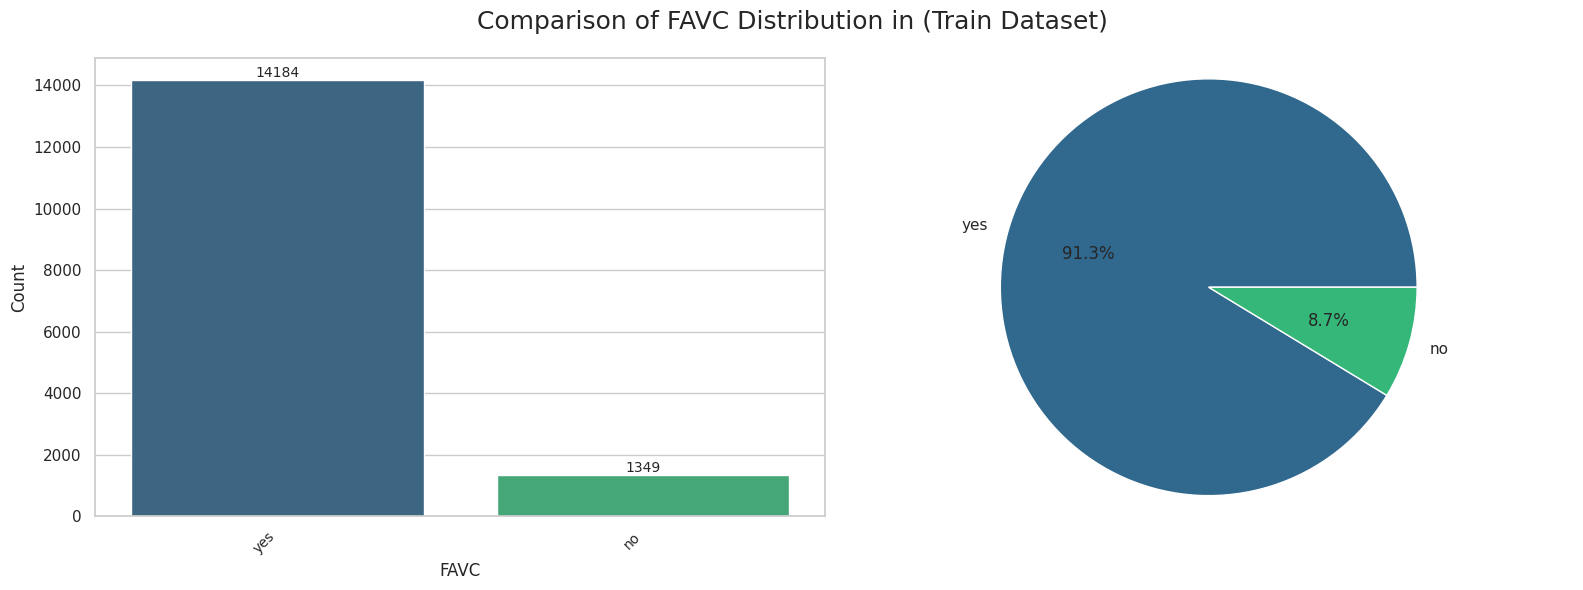

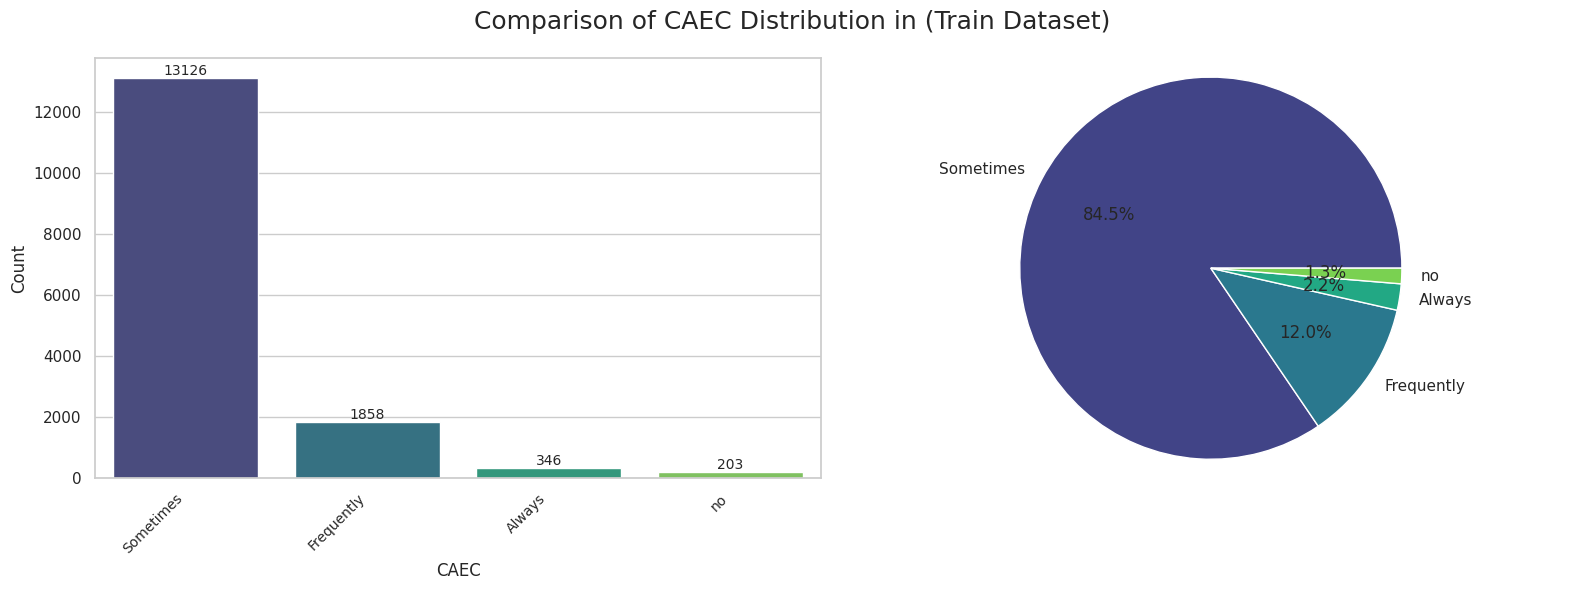

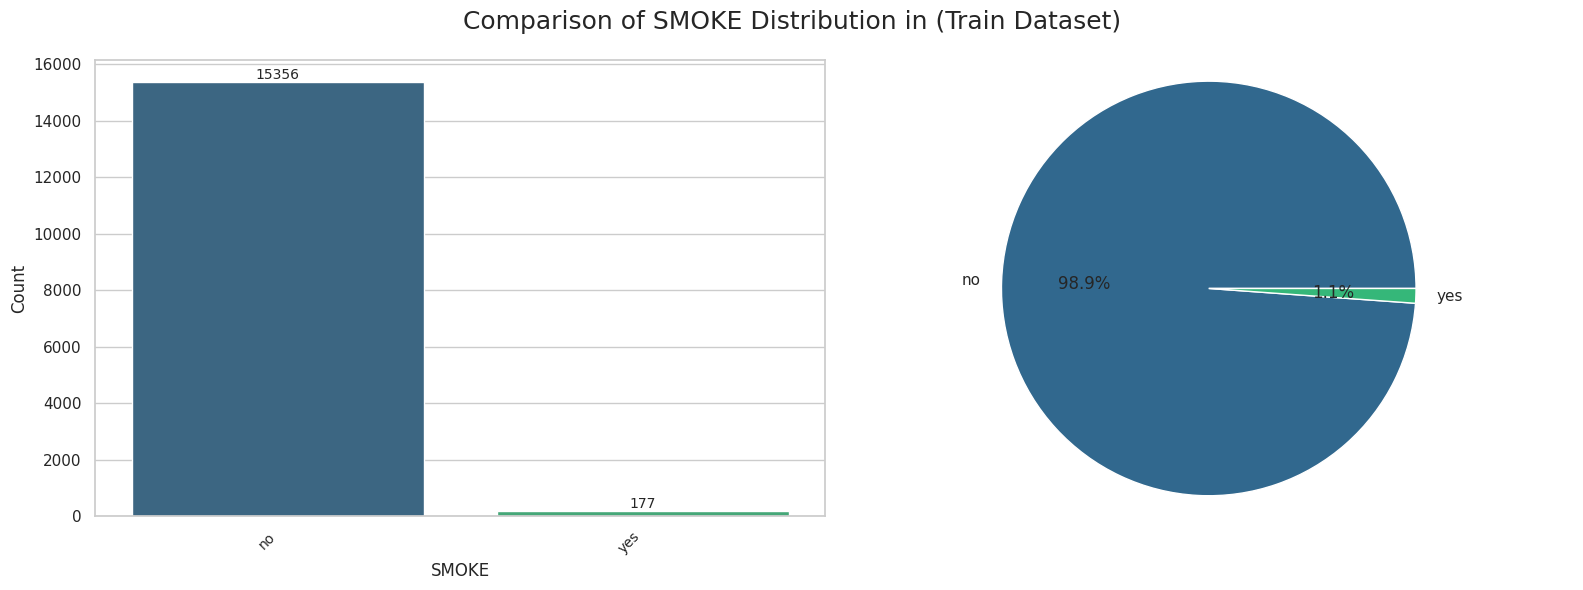

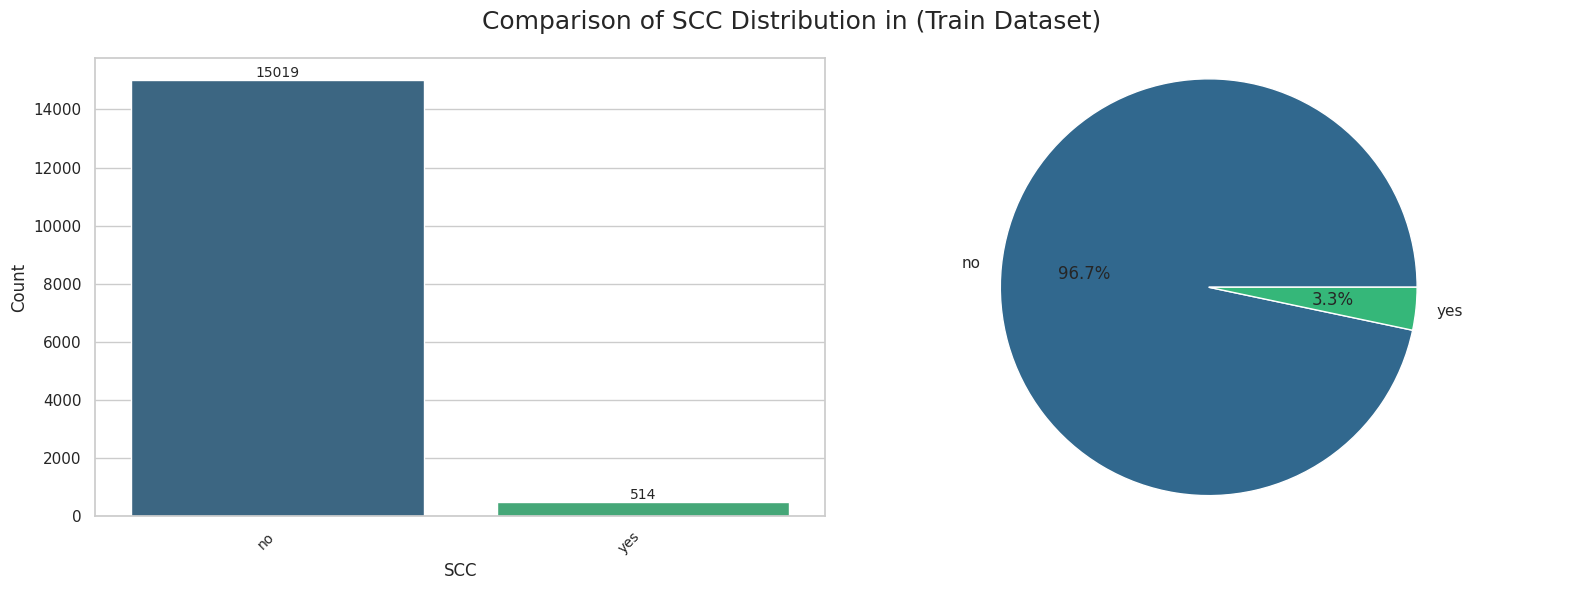

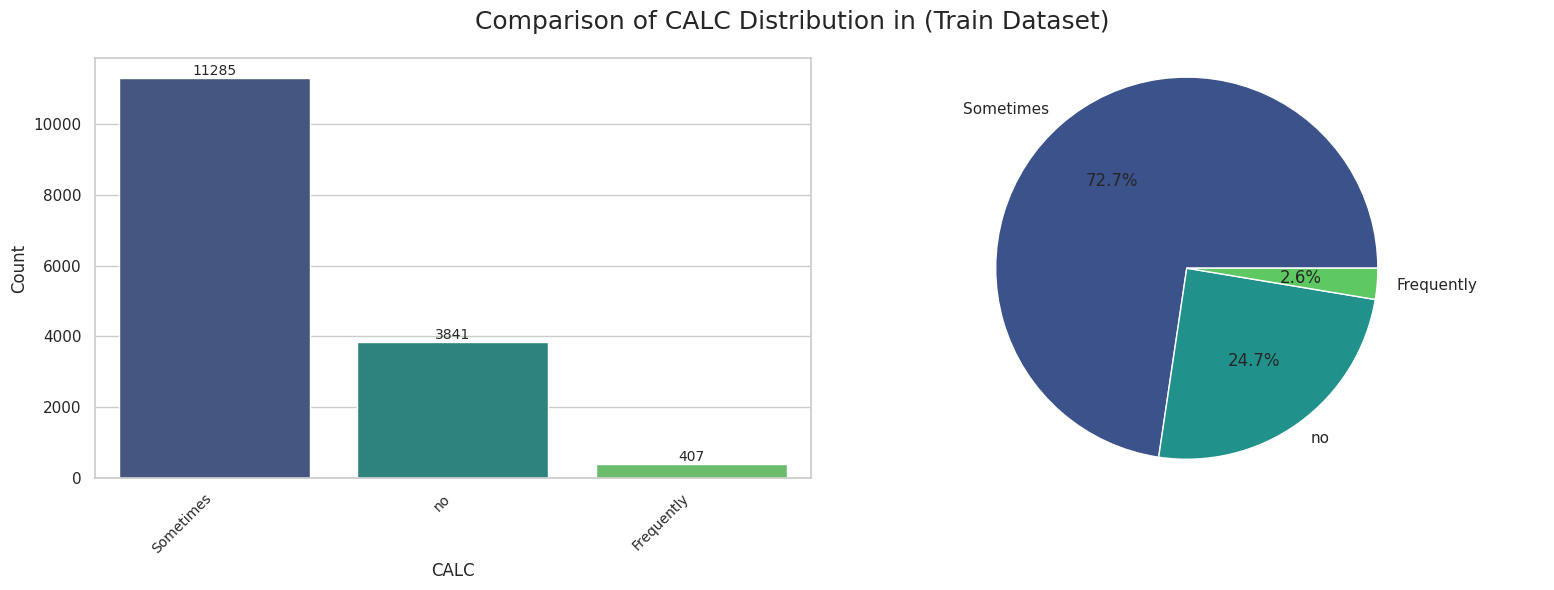

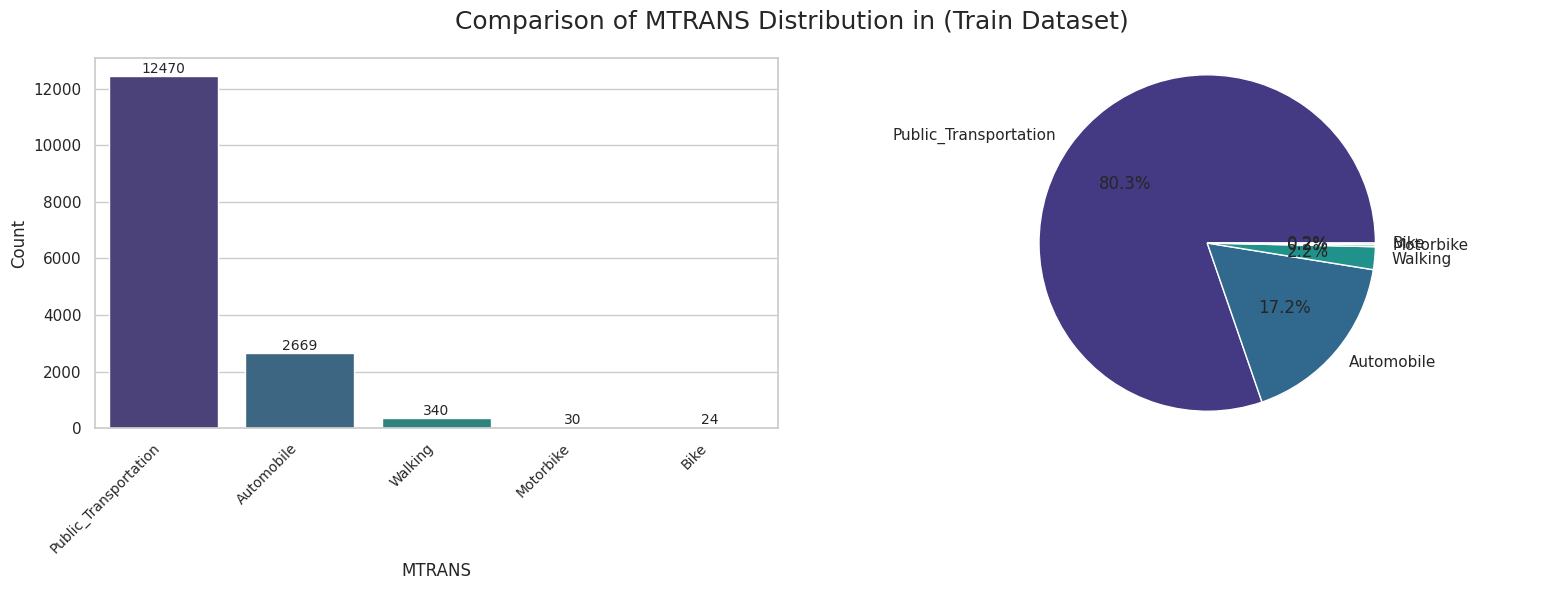

In [109]:
train_data.name = "Train Dataset"

for column in categorical_vars:
    plot_distribution(train_data,column)

* Gender : we can see a balanced distribution, as females accounted for 50.1% of the survey and males accounted for 49.9%.
* Family history with overweight : Above, we can see that the distribution for 'family_history_with_overweight' is imbalanced. The vast majority of individuals (82%) have a family member who suffers or has sufferred from being overweight. This is intriguing, as one could postulate that particular diets or habits passed down through the family could further contribute to overweight/obesity rates of younger family members.
* FAVC : As with 'family_history_with_overweight', 'FAVC' (frequent consumption of high caloric food) shows an imbalanced distribution. Here, roughly 91.3% of individuals have admitted to the frequent consumption of high caloric foods. As briefly discussed in the Introduction section, it is believed that obesity has a strong association with the consumption of ultra-processed foods. From this, we could suggest that the individuals who are frequently consuming high caloric foods may also likely be overweight or obese.
* CAEC : Above, we can see the distribution of 'CAEC', i.e. the consumption of food between meals. This distributuion is also imbalanced, as the majority (84.5%) of individuals reported to eat between meals sometimes. Moreover, a significant minority (1.3%) reported to not eat at all between meals.
* Smoke : Here, we can see that the distribution of 'SMOKE' (smoker or not) is also highly imbalanced. 98.9% of the individuals reported to not smoke. This distribution seems unlikely, as quick research provides us with contradictory evidence. Moreover, estimates are that smoking is responsible for roughly 12% of total adult deaths. From this, we may argue that it is unlikely that only 1.2% of survey participants are smokers.
* SCC : The plot above shows another imbalanced distribution for 'SCC' (calories consumption monitoring). Here, only 3.3% of individuals reported to monitor their consumption of calories.
* CALC : 'CALC' represents the consumption of alcohol. The majority (72.7%) of individuals reported to consume alcohol sometimes, while 24.7% reported to not drink, and only 2.6% reported to drink frequently.
* MTRANS : represents the type of transportation frequently used by a given individual. Here, we can see that the vast majority (80.3%) of individuals rely on public transportation. This accounts for 12470 individuals, which greatly outnumbers the 340 individuals who walk and the  24 individuals who bike. Given the high rates of individuals who are either overweight or obese (shown in WeightCategory), it is not surprising to see the reliance on public transportation or automobiles.

## Numerical predictors
This section highlights the distributions of each numerical predictor. The distributions are visualized via the use of kernel density estimate plots (similar to histograms). Furthermore, this section leverages a heatmap to examine potential correlations amongst the numerical predictors. The numerical predictors include:

Age,Height,Weight,FCVC,NCP,CH20,FAF,TUE

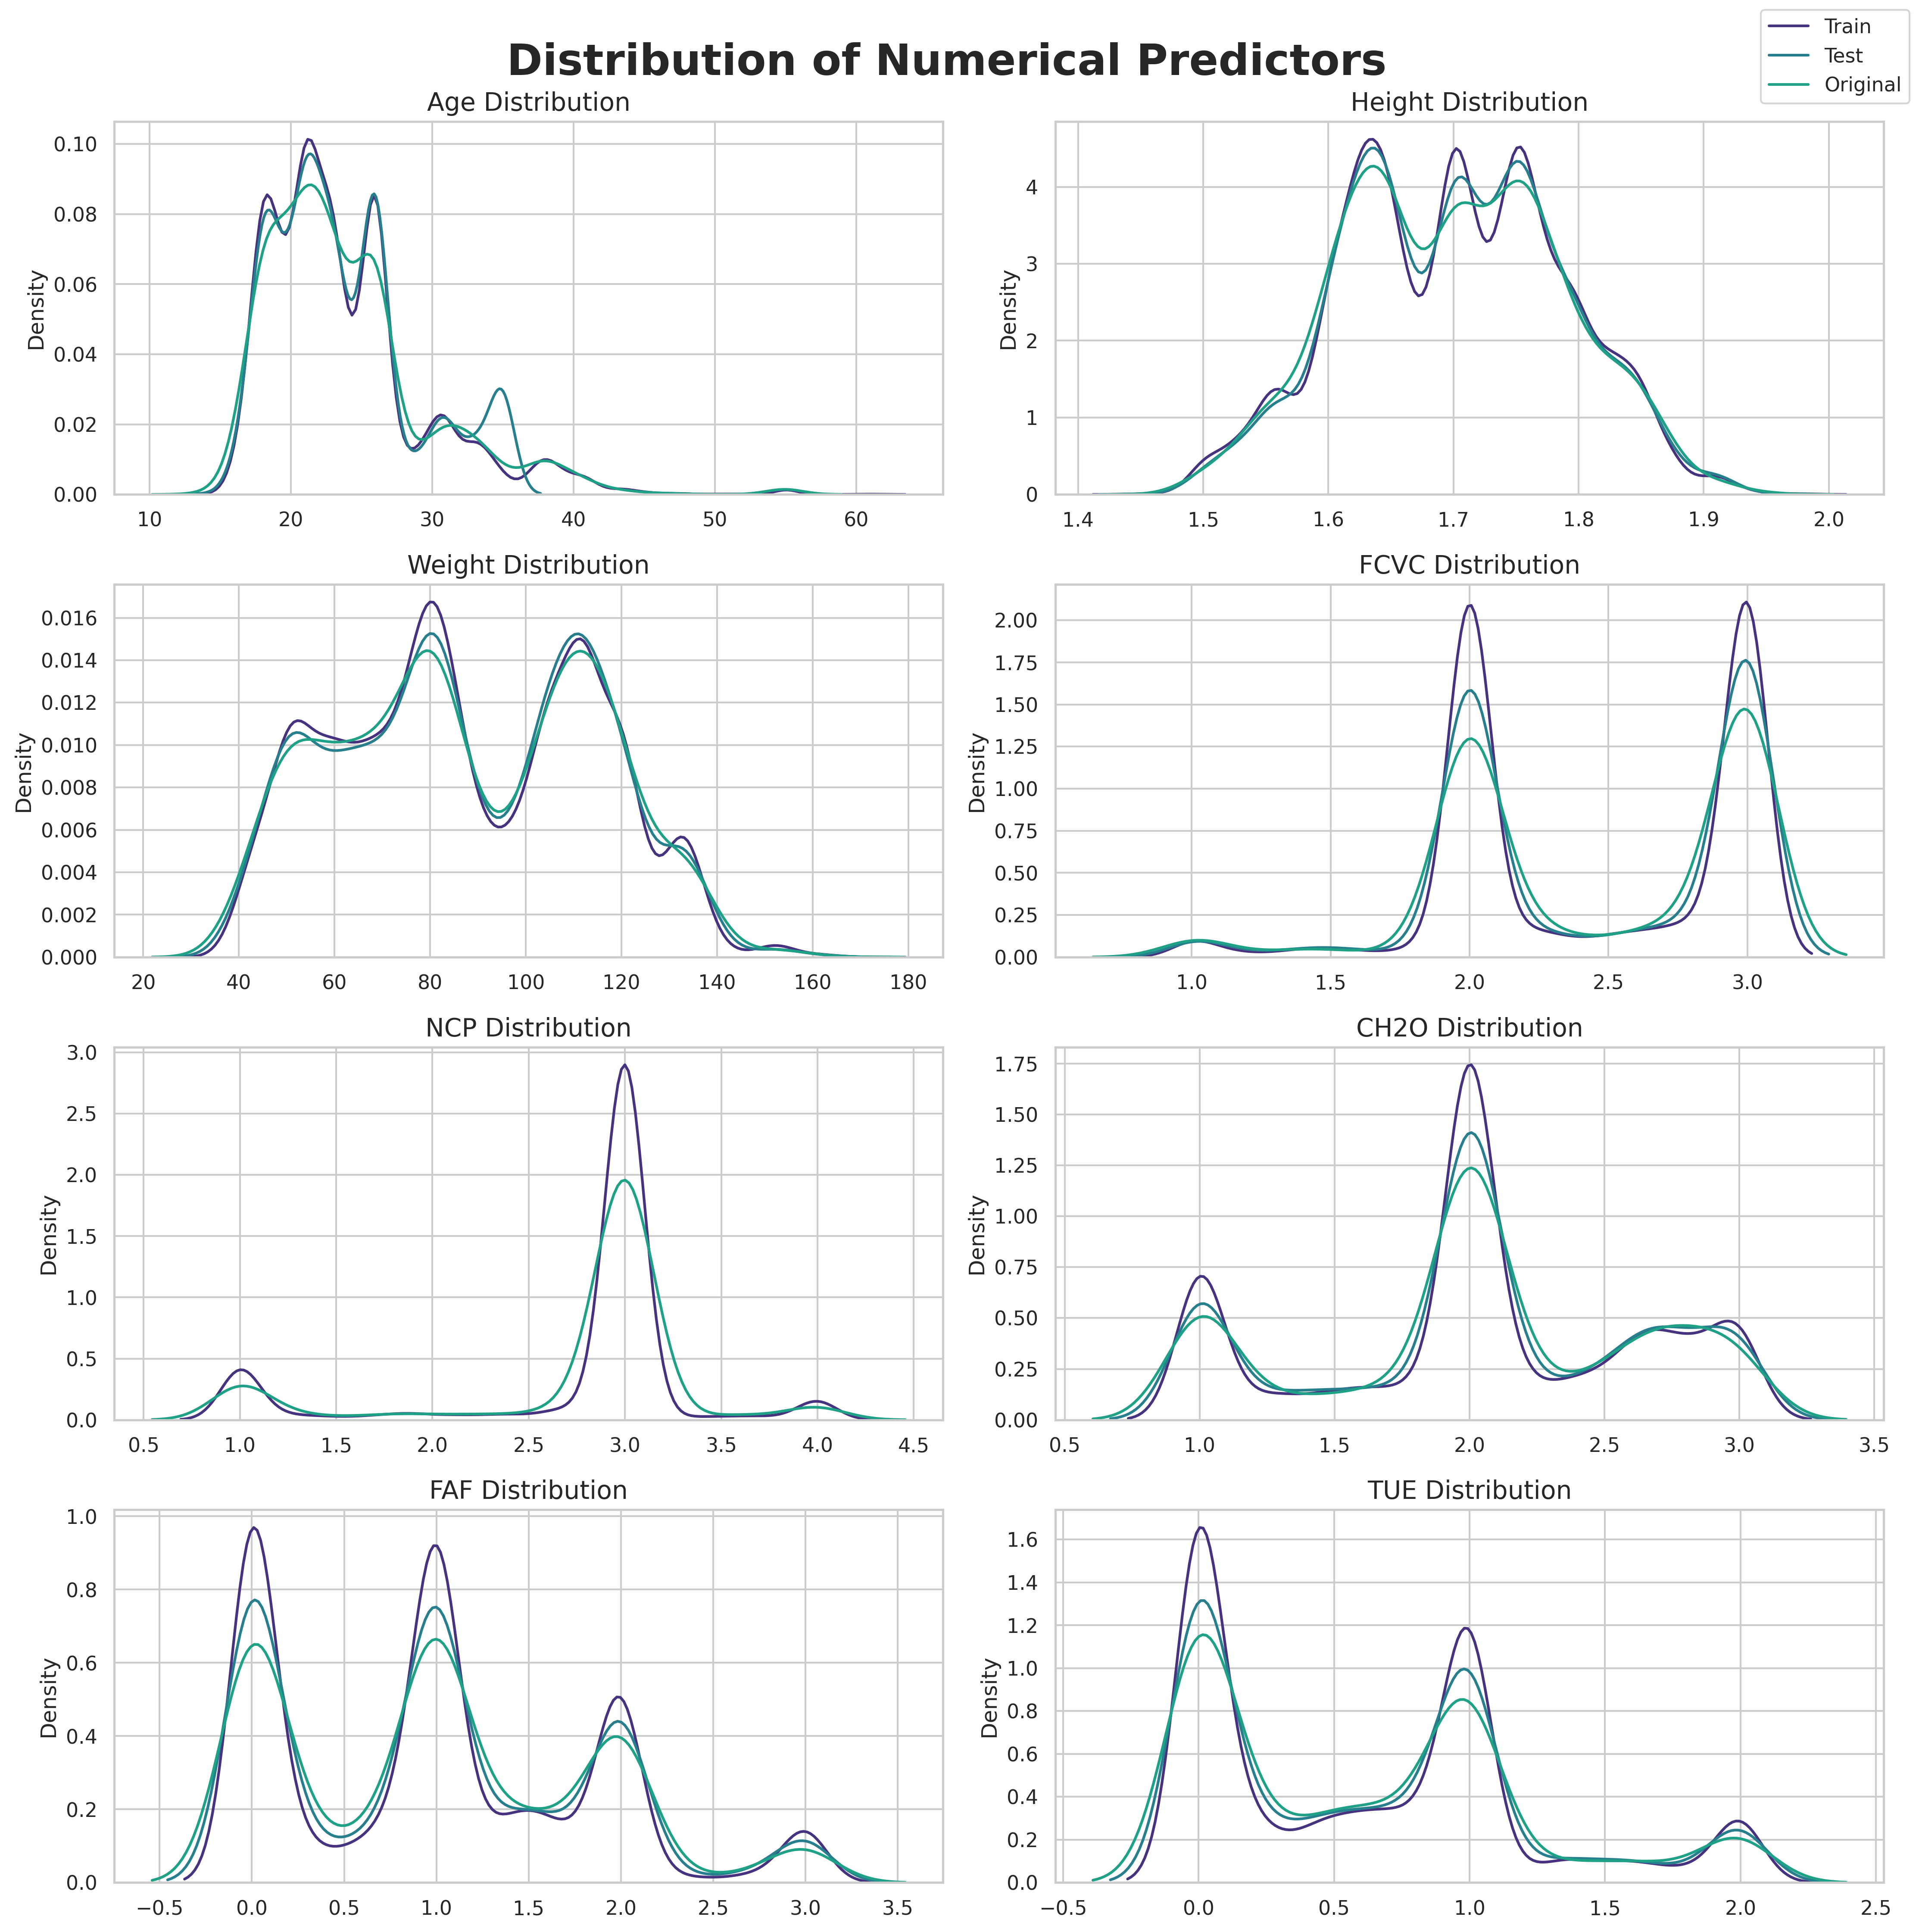

In [110]:
# Visualizing distributions of numerical predictors
pal = sns.color_palette('viridis')

fig, ax = plt.subplots(4, 2, figsize = (15, 15), dpi = 300)
ax = ax.flatten()
train_numerical = train_data.drop(['id', 'Gender', 'family_history_with_overweight', 'FAVC',
                            'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'WeightCategory'], axis=1)
features = train_numerical.columns

for i, column in enumerate(features):
        
    sns.kdeplot(train_data[column], ax=ax[i], color=pal[0])
    sns.kdeplot(test_data[column], ax=ax[i], color=pal[2],warn_singular = False)
    sns.kdeplot(original_data[column], ax=ax[i], color=pal[3],warn_singular=False)
    
    ax[i].set_title(f'{column} Distribution', size = 14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Numerical Predictors', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test','Original'])
plt.tight_layout()

The plots above show the distributions of each numerical predictor for the train, test and original datasets. By showing this, we can verify that the train and test datasets have similar attribute distributions. At a glance, we can see that many of the numerical predictors have imbalanced distributions. For example, in 'Age', there are many more individuals between 15 and 30 years old than there are individuals who are older than 30. This may be due to the fact that younger individuals tend to be more technologically savvy and thus were more likely to participate in the online survey. Other imbalanced predictors include 'Weight', 'FCVC', 'NCP', 'CH20', 'FAF', and 'TUE'. For 'Weight', it is interesting to see that many individuals are either roughly 80kg or roughly 110kg, but far fewer individuals are roughly 95kg. This discrepancy can be visualized by the valley between the two majority peaks. Another interesting finding is that in 'FCVC' (frequent consumption of vegetables), many more individuals do in fact consume vegetables. This is intriguing, as the exploration of the categorical predictor 'FAVC' showed us that many individuals also frequently consume high caloric foods.

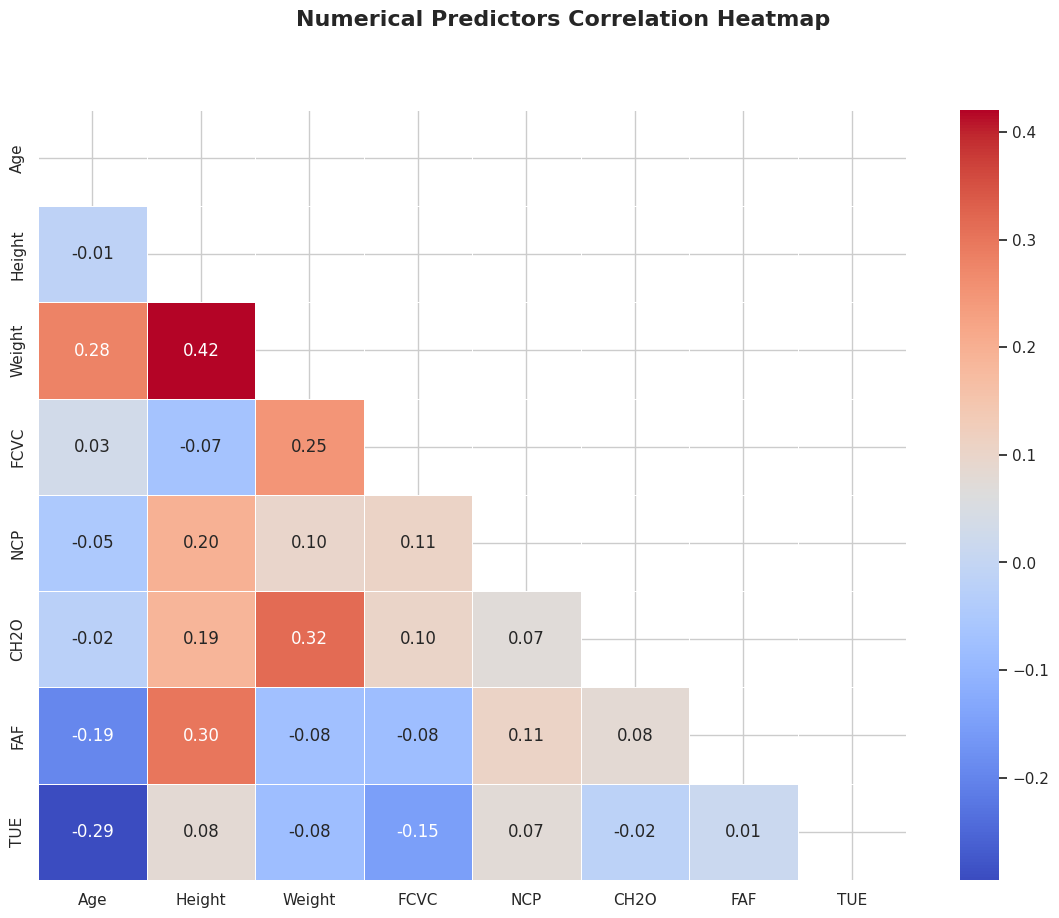

In [111]:
# Plotting correlation heatmap of numerical predictors
plt.figure(figsize=(14,10))
corr=train_numerical.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm',mask=np.triu(corr), linewidths=0.5, fmt=',.2f')
plt.suptitle('Numerical Predictors Correlation Heatmap', fontsize=16, fontweight='bold')
plt.show()

In the heatmap above, we can see that the strongest positive correlation amongst the numerical predictors is a 0.42 correlation between 'Weight' and 'Height'. Relatively speaking, this correlation is not very strong, but the finding is fairly obvious, as taller individuals tend to weigh more than shorter individuals. The second strongest positive correlation is 0.32 between 'CH20' and 'Weight'. This correlation is also not very significant but it is interesting to ponder the loose connection between one's weight and their consumption of water. The strongest negative correlation was -0.30 between 'TUE' (time using technology devices) and 'Age'. This correlation also seems self-explanatory, as one could postulate that younger individuals are more likely to frequently use technology than older individuals.

## Alignment Of Train Data

In [112]:

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

original_df = pd.read_csv('../data/ObesityDataSet.csv')
original_df.rename(columns={'NObeyesdad': 'WeightCategory'}, inplace=True)

traindata_df = pd.read_csv('../data/train.csv')

# Define target column
TARGET = "WeightCategory"
target_col = "WeightCategory"


print(f"Original Data Shape: {original_df.shape}")
print(f"Training Data Shape: {traindata_df.shape}")


Original Data Shape: (2111, 17)
Training Data Shape: (15533, 18)


In [113]:
def adjust_classwise_distribution(syn_df, ref_df, feature, target_col):
    """
    Adjusts the mean and standard deviation of each class for a numeric feature
    in the synthetic dataset to match the same stats from the original dataset.
    """
    aligned = syn_df.copy()

    # Compute stats per class
    ref_stats = ref_df.groupby(target_col)[feature].agg(['mean', 'std'])
    syn_stats = syn_df.groupby(target_col)[feature].agg(['mean', 'std'])

    for cls in ref_stats.index:
        if cls not in syn_stats.index:
            continue
        mean_ref, std_ref = ref_stats.loc[cls]
        mean_syn, std_syn = syn_stats.loc[cls]

        if std_ref == 0 or std_syn == 0 or np.isnan(std_ref) or np.isnan(std_syn):
            continue

        mask = aligned[target_col] == cls
        aligned.loc[mask, feature] = (
            (aligned.loc[mask, feature] - mean_syn) / std_syn * std_ref + mean_ref
        )
    return aligned


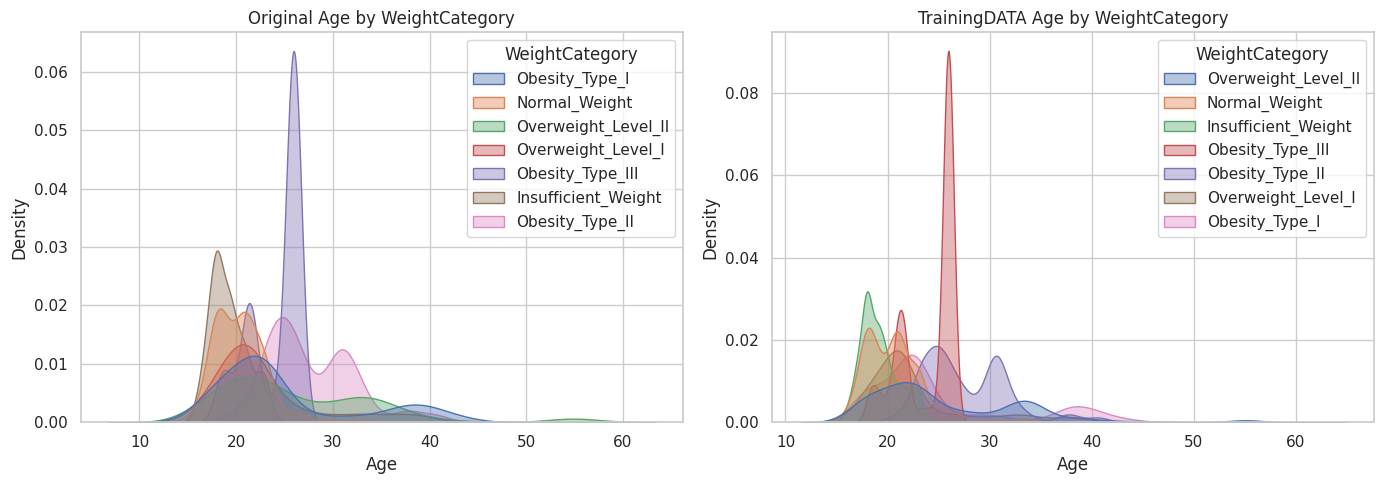

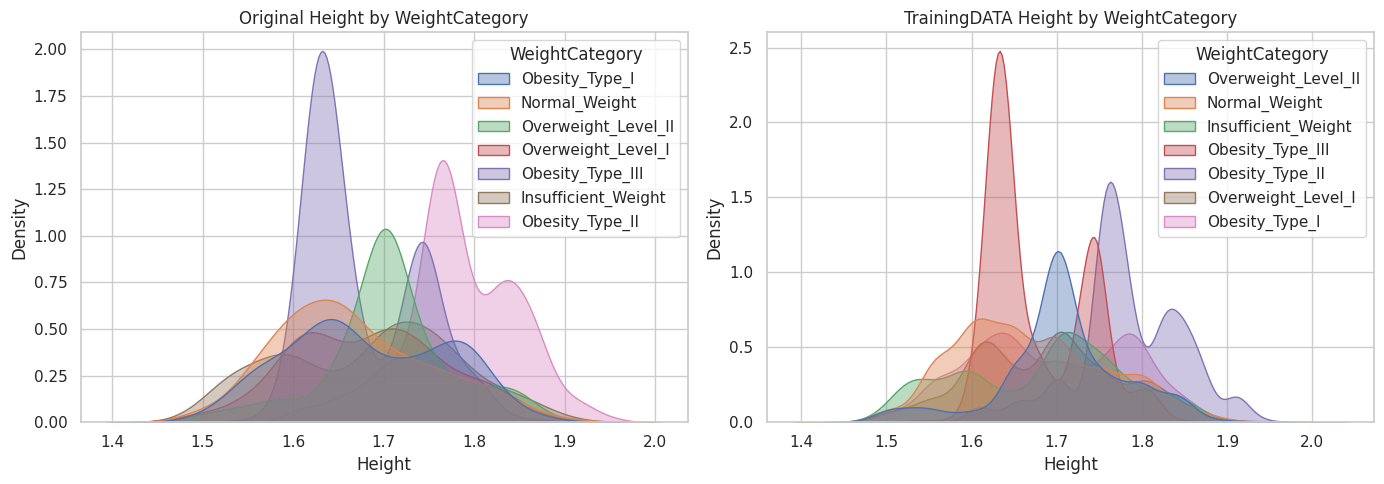

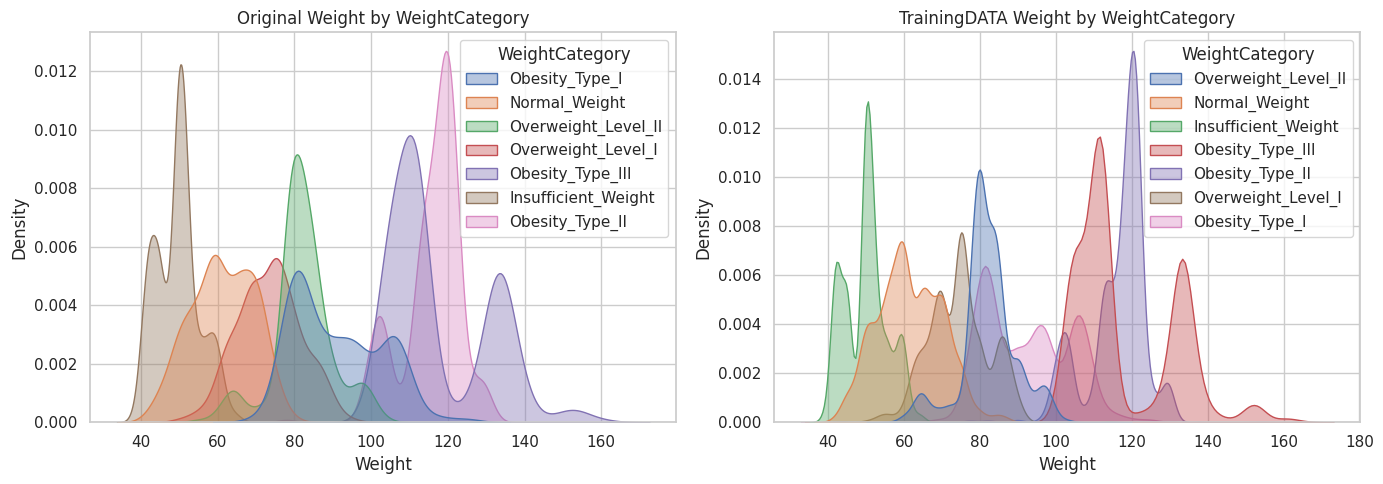

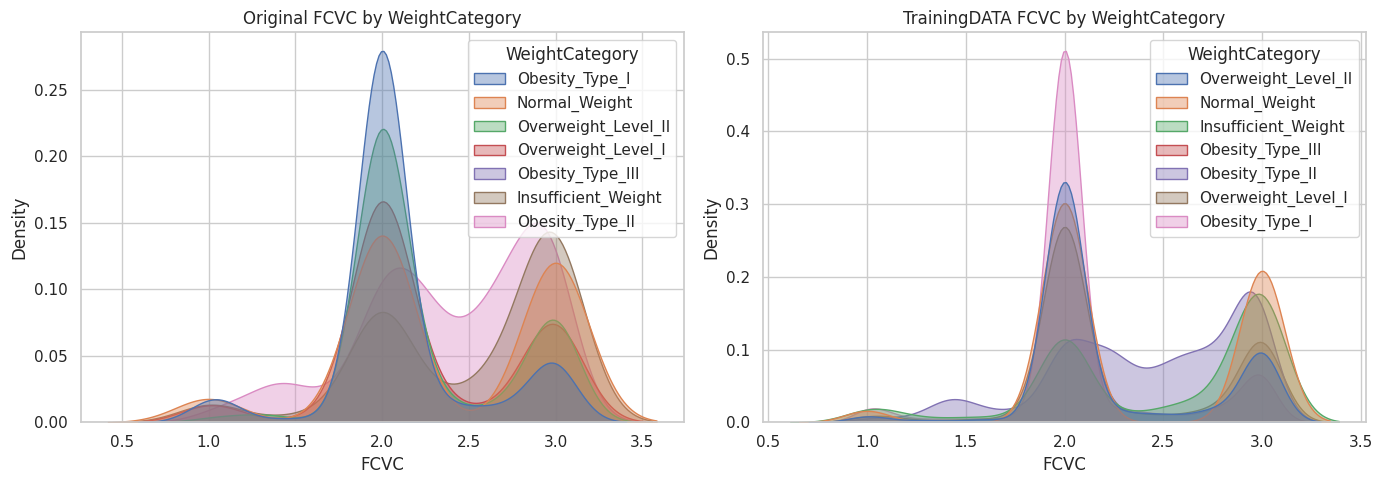

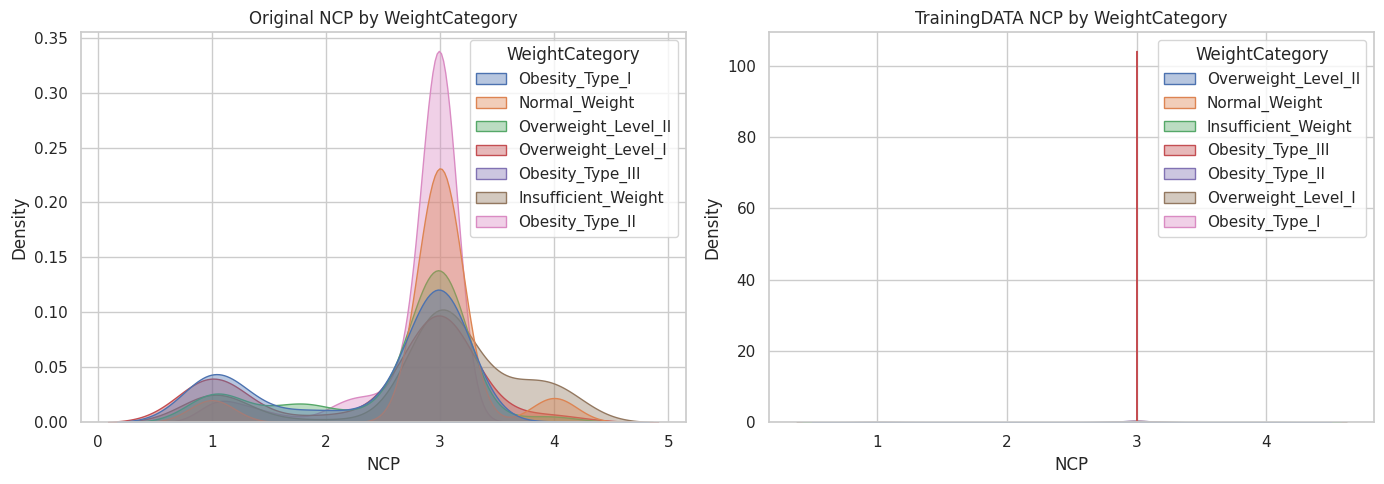

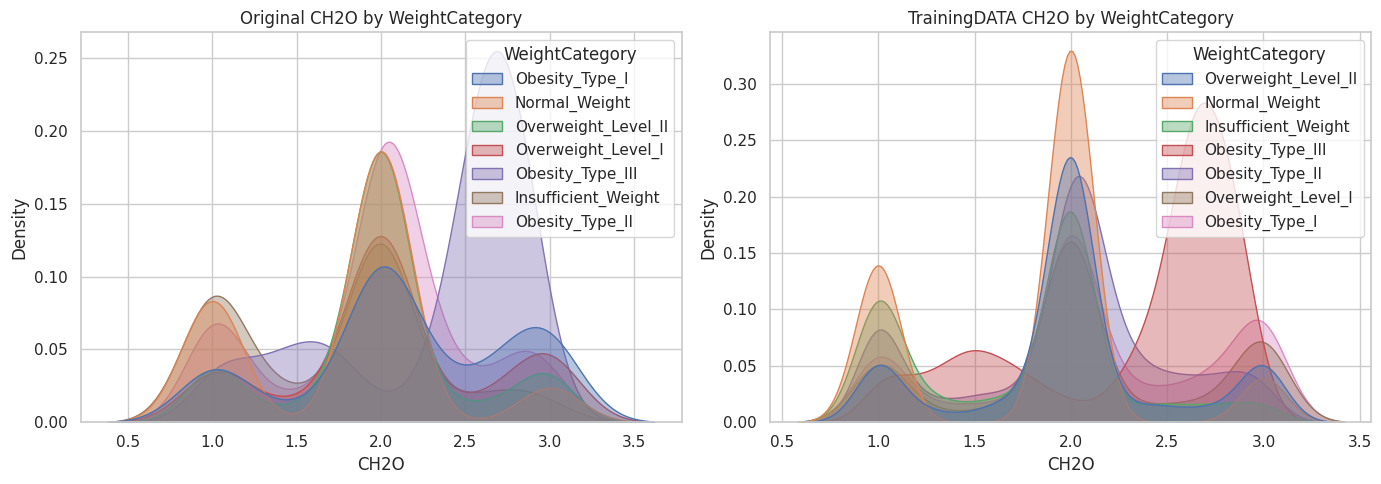

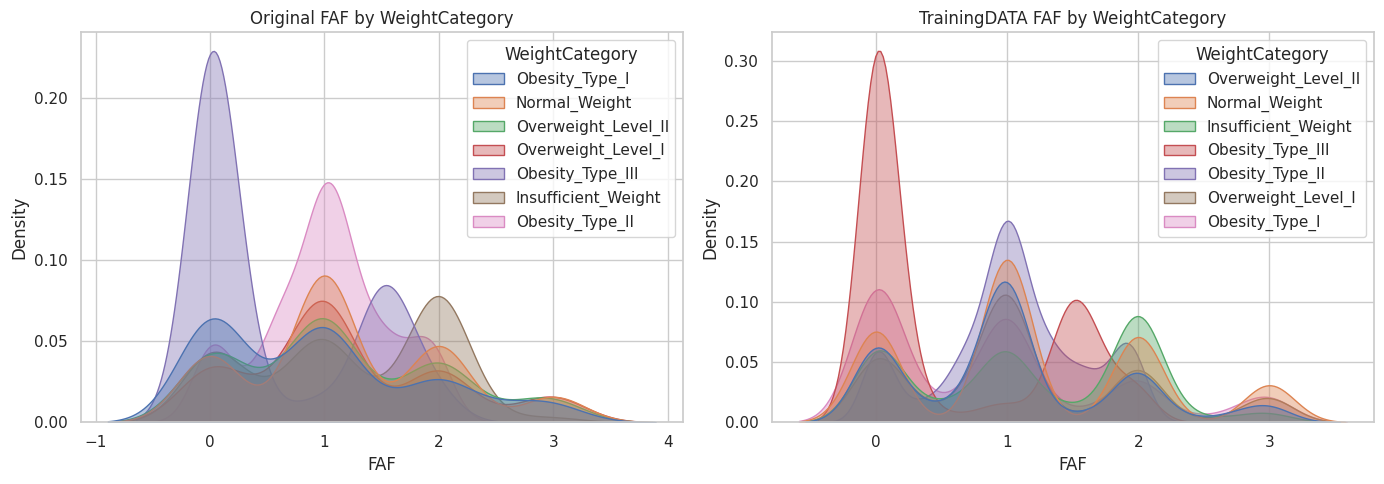

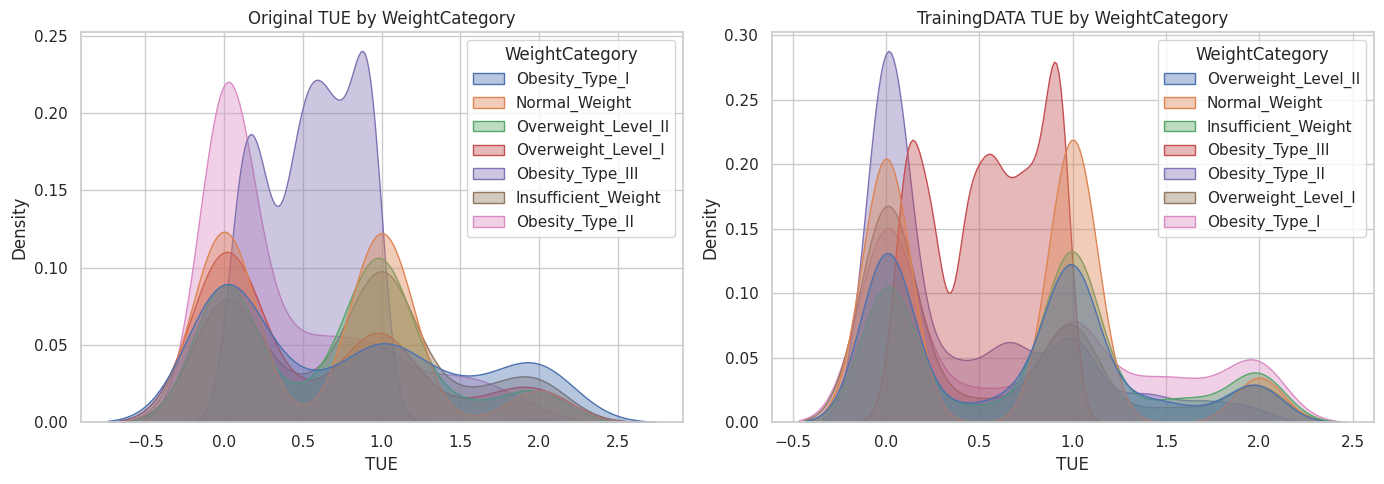

 Visualization done — You can see classwise distribution differences for all numerical features.


In [114]:


# Identify numerical features
numerical_features = original_df.select_dtypes(include=['int64','float64']).columns.tolist()
numerical_features = [f for f in numerical_features if f != target_col]  # exclude target

for feat in numerical_features:
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    sns.kdeplot(data=original_df, x=feat, hue=target_col, fill=True, alpha=0.4)
    plt.title(f"Original {feat} by {target_col}")
    
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=traindata_df, x=feat, hue=target_col, fill=True, alpha=0.4)
    plt.title(f"TrainingDATA {feat} by {target_col}")
    
    plt.tight_layout()
    plt.show()

print(" Visualization done — You can see classwise distribution differences for all numerical features.")


In [115]:

to_fix = ["Weight", "Age"]

train_aligned = traindata_df.copy()
for col in to_fix:
    train_aligned = adjust_classwise_distribution(train_aligned, original_df, col, target_col)

print(" Classwise alignment done for Age & Weight features.")


 Classwise alignment done for Age & Weight features.


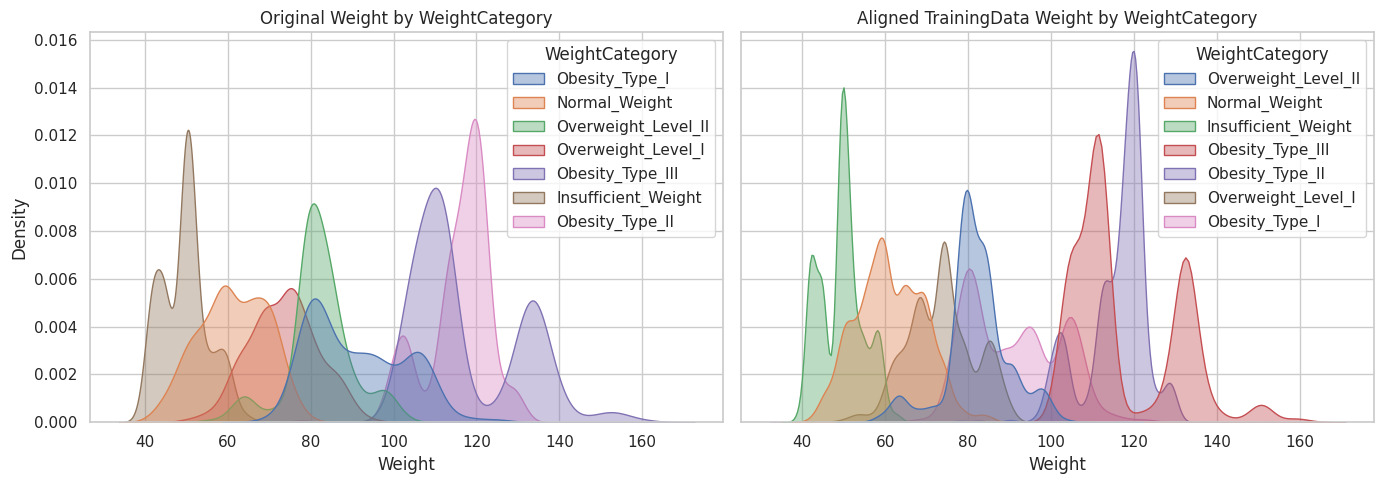

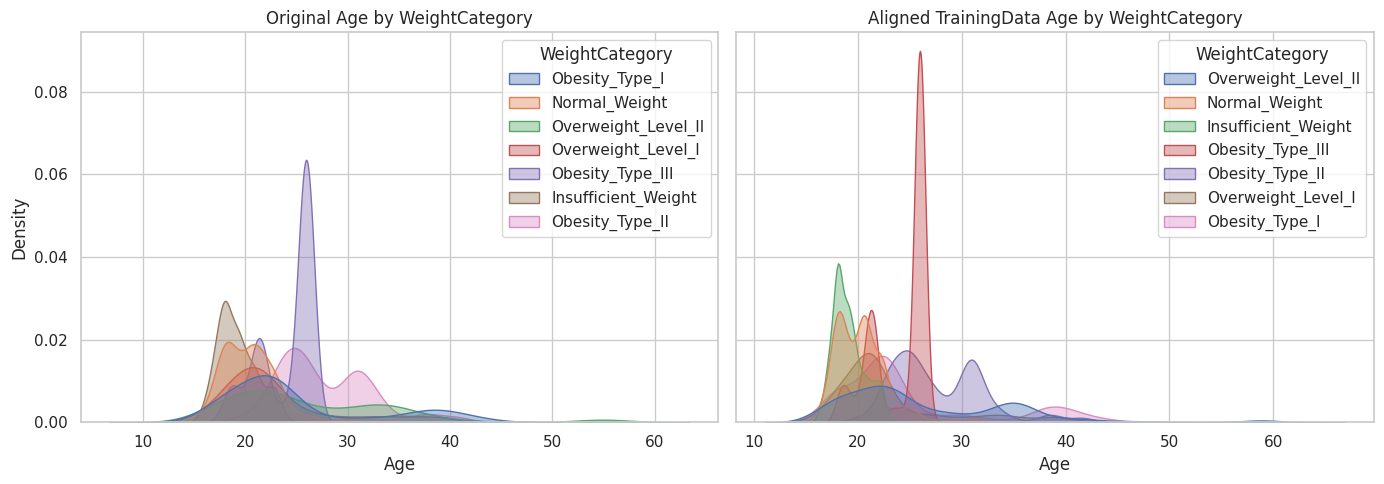

In [116]:

#  Check Alignment Result
for col in to_fix:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    sns.kdeplot(data=original_df, x=col, hue=target_col, fill=True, alpha=0.4, ax=axes[0])
    axes[0].set_title(f"Original {col} by {target_col}")

    sns.kdeplot(data=train_aligned, x=col, hue=target_col, fill=True, alpha=0.4, ax=axes[1])
    axes[1].set_title(f"Aligned TrainingData {col} by {target_col}")

    plt.tight_layout()
    plt.show()


### Original vs Train Data Comparison & Alignment

We compared all numerical features in the original and Train datasets, grouped by `WeightCategory`.

- Side-by-side plots show **original data** (left) vs **Train data** (right).  
- The goal was to identify differences in classwise distributions, especially for **Age** and **Weight**.

**Observation:** Age and Weight distributions in the train dataset differed noticeably from the original dataset.

**Alignment:** To correct this, we applied **classwise mean and standard deviation alignment** on the features:  
- **Features aligned:** Age and Weight  
- Each class in the train data was rescaled to match the corresponding **mean and standard deviation** in the original dataset.

This step ensures the synthetic data better reflects the original patterns before any modeling.


# Feature Engineering and processing

In [117]:
TARGET = "WeightCategory"
n_splits = 9

In [118]:
def age_rounder(x):
    x_copy = x.copy()
    x_copy['Age'] = (x_copy['Age']*100).astype(np.uint16)
    return x_copy

def height_rounder(x):
    x_copy = x.copy()
    x_copy['Height'] = (x_copy['Height']*100).astype(np.uint16)
    return x_copy

def extract_features(x):
    x_copy = x.copy()
    x_copy['BMI'] = (x_copy['Weight']/x_copy['Height']**2)
    return x_copy

def col_rounder(x):
    x_copy = x.copy()
    cols_to_round = ['FCVC','NCP','CH20','FAF','TUE']
    for col in cols_to_round:
        x_copy[col] = round(x_copy[col])
        x_copy[col] = x_copy[col].astype(int)
    return x_copy
from sklearn.preprocessing import FunctionTransformer
AgeRounder = FunctionTransformer(age_rounder)
HeightRounder = FunctionTransformer(height_rounder)
ExtractFeatures = FunctionTransformer(extract_features)
ColumnRounder = FunctionTransformer(col_rounder)


- **`age_rounder`**: Converts the `Age` column to an integer representation by multiplying by 100. Helps in removing decimals and standardizing age values.  
- **`height_rounder`**: Converts the `Height` column to centimeters (multiplies by 100) and casts it as integers for consistency.  
- **`extract_features`**: Creates a new feature `BMI` (Body Mass Index) using the formula:  
  `BMI = Weight / Height^2`
  which can help the model capture obesity-related patterns.  
- **`col_rounder`**: Rounds selected numeric columns (`FCVC`, `NCP`, `CH20`, `FAF`, `TUE`) to integers to reduce noise and simplify categorical-like numeric variables.  
- **FunctionTransformer wrappers**:  
  - `AgeRounder`, `HeightRounder`, `ExtractFeatures`, and `ColumnRounder` are sklearn-compatible transformers that allow integrating these functions directly into **pipelines**.


In [119]:
from sklearn.base import BaseEstimator, TransformerMixin
class FeatureDrop(BaseEstimator, TransformerMixin):
    def __init__(self,cols):
        self.cols = cols
    def fit(self,x,y):
        return self
    def transform(self,x):
        return x.drop(self.cols, axis=1)


- **Purpose**: Custom sklearn-compatible transformer to **drop specified columns** from a DataFrame.  
- **`__init__(self, cols)`**: Takes a list of column names to drop.  
- **`fit(self, x, y)`**: Does nothing and returns `self` (required for sklearn compatibility).  
- **`transform(self, x)`**: Drops the specified columns from the input DataFrame `x` and returns the modified DataFrame.  

This can be used directly in **scikit-learn pipelines** to remove unnecessary or redundant features before modeling.


In [120]:
train_data.head()


id  Gender        Age    Height      Weight family_history_with_overweight  \
0   0    Male  24.443011  1.699998   81.669950                            yes   
1   1  Female  18.000000  1.560000   57.000000                            yes   
2   2  Female  18.000000  1.711460   50.165754                            yes   
3   3  Female  20.952737  1.710730  131.274851                            yes   
4   4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC                 MTRANS       WeightCategory  
0  0.976473  Sometimes  Public_Transportation  Overweight_Level_II  
1  1.000000         no             Automobile        Normal_Weight  
2  1.673584         no  Public_Transportation  Insufficient_Weight  
3  0.780199  Sometimes  Public_Transportation     Obesity_Type_III  
4  0.931721  Sometimes  Public_Transportation  Overweight_Level_II

In [121]:



# Drop id from both train and test
train_data = train_data.drop(columns=['id'], errors='ignore')
test_data = test_data.drop(columns=['id'], errors='ignore')

# Also drop 'id' from original_data if it exists
original_data = original_data.drop(columns=['id'], errors='ignore')

# Combine and remove duplicates
train = pd.concat([train_data, original_data], axis=0).drop_duplicates()
train.reset_index(drop=True, inplace=True)



Combining treain data and orignal data


Next we will define cross_val_model which will be used to train and validate all the models we will use in this Notebook¶
cross_val_model function gives three things: val_scores, valid_preds, test_preds

* val_scores: This gives us accuracy score on Validation Data.
* valid_preds: This is a array which stores model predictions on validation set
* test_preds: This gives test prediction averaged by number of splits we are using

In [122]:


from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skf = StratifiedKFold(n_splits=n_splits)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score
import numpy as np

target_mapping = {
                  'Insufficient_Weight':0,
                  'Normal_Weight':1,
                  'Overweight_Level_I':2,
                  'Overweight_Level_II':3, 
                  'Obesity_Type_I':4,
                  'Obesity_Type_II':5 ,
                  'Obesity_Type_III':6
                  }

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skf = StratifiedKFold(n_splits=n_splits)

def cross_val_model(estimators, cv=skf,verbose=True):
    X = train.copy()
    y = X.pop(TARGET)
    y = y.map(target_mapping)
    
    test_preds = np.zeros((len(test_data),7))
    valid_preds = np.zeros((len(X),7))
    
    val_scores, train_scores = [],[]
    for fold, (train_ind,valid_ind) in enumerate(skf.split(X,y)):
        model = clone(estimators)
        #define train set
        X_train = X.iloc[train_ind]
        y_train = y.iloc[train_ind]
        #define valid set
        X_valid = X.iloc[valid_ind]
        y_valid = y.iloc[valid_ind]
        model.fit(X_train,y_train)
        if verbose:
            print("-" * 100)
            print(f"Fold: {fold}")
            print(f"Train Accuracy Score:-{accuracy_score(y_true=y_train,y_pred=model.predict(X_train))}")
            print(f"Valid Accuracy Score:-{accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid))}")
            print("-" * 100)
            
        test_preds += model.predict_proba(test_data)/cv.get_n_splits()
        valid_preds[valid_ind] = model.predict_proba(X_valid)
        val_scores.append(accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid)))
    if verbose:
        print(f'Average Mean Accuracy Score:- {np.array(val_scores).mean()}')
        
    return val_scores, valid_preds, test_preds

In [123]:
# empty dataframe to store score, & train / test predictions.
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# Models

Rather than combining multiple models, in this notebook we focus on training **several different types of models** separately and selecting the one with the **highest validation accuracy** for the final submission.  

The models we train in this notebook are:  

- **Decision Tree**  
- **K-Nearest Neighbors (KNN)**  
- **Random Forest**  
- **XGBoost**  

We evaluate each model using cross-validation and pick the model with the **highest validation accuracy** for predicting the test dataset.


## Decision Trees Pipeline

In [124]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import MEstimateEncoder
RANDOM_SEED = 42  



# Pipeline
dt = make_pipeline(
    ExtractFeatures,
    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                           'SMOKE','SCC','CALC','MTRANS']),
    DecisionTreeClassifier(random_state=RANDOM_SEED)
)

# Run cross-validation
val_scores_dt, valid_preds_dt, test_preds_dt = cross_val_model(dt, verbose=True)

# Save OOF predictions for later use
for k,v in target_mapping.items():
    oof_list[f"dt_{k}"] = valid_preds_dt[:,v]
    predict_list[f"dt_{k}"] = test_preds_dt[:,v]

print(f"\n Decision Tree Average CV Accuracy: {np.mean(val_scores_dt):.4f}")


----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-1.0
Valid Accuracy Score:-0.8357980622131566
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-1.0
Valid Accuracy Score:-0.8424273329933707
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-1.0
Valid Accuracy Score:-0.8322284548699643
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy Score:-1.0
Valid Accuracy Score:-0.8352881183

## KNN Pipeline

In [125]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler  

# Pipeline
knn = make_pipeline(
    ExtractFeatures,
    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                           'SMOKE','SCC','CALC','MTRANS']),
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)  
)

# Run cross-validation
val_scores_knn, valid_preds_knn, test_preds_knn = cross_val_model(knn, verbose=True)

# Save OOF predictions for later use
for k,v in target_mapping.items():
    oof_list[f"knn_{k}"] = valid_preds_knn[:,v]
    predict_list[f"knn_{k}"] = test_preds_knn[:,v]

# Print summary
print(f"\n KNN Average CV Accuracy: {np.mean(val_scores_knn):.4f}")


----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.8373397946821399
Valid Accuracy Score:-0.7593064762876084
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.8354906586749984
Valid Accuracy Score:-0.7654258031616522
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.8365746349550469
Valid Accuracy Score:-0.7756246812850587
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy 

## Random Forest Pipeline

In [126]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from category_encoders import MEstimateEncoder

RANDOM_SEED = 73

# Default RandomForest model
rfc_default = make_pipeline(
    ExtractFeatures,
    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                           'SMOKE','SCC','CALC','MTRANS']),
    RandomForestClassifier(random_state=RANDOM_SEED)
)

# Evaluate default model
val_scores_rf_default, valid_preds_rf_default, test_preds_rf_default = cross_val_model(rfc_default)

# print("Default RandomForest mean validation accuracy:", val_scores_rf_default.mean())

# Save predictions for analysis (optional)
for k, v in target_mapping.items():
    oof_list[f"rfc_default_{k}"] = valid_preds_rf_default[:, v]
    predict_list[f"rfc_default_{k}"] = test_preds_rf_default[:, v]


----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-1.0
Valid Accuracy Score:-0.8964813870474247
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-1.0
Valid Accuracy Score:-0.8969913309535951
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-1.0
Valid Accuracy Score:-0.9010708822029577
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy Score:-1.0
Valid Accuracy Score:-0.8949515553

In [127]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from category_encoders import MEstimateEncoder

RANDOM_SEED = 73

rfc = make_pipeline(
    ExtractFeatures,
    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                           'SMOKE','SCC','CALC','MTRANS']),
    RandomForestClassifier(random_state=RANDOM_SEED)
)


In [128]:

# Hyperparameter Tuning for RandomForest


# Extract features and target for tuning
X = train.drop(TARGET, axis=1)
y = train[TARGET].map(target_mapping)

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

def rf_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    
    clf = Pipeline([
        ('features', ExtractFeatures),
        ('encoder', MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS'])),
        ('rf', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=RANDOM_SEED))
    ])
    
    return cross_val_score(clf, X, y, cv=3, scoring='accuracy').mean()

study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=30)

print("Best RF Params:", study.best_params)


[I 2025-10-26 08:21:29,430] A new study created in memory with name: no-name-4d576ecf-a155-4aa4-95de-3623f1b264ef
[I 2025-10-26 08:22:09,757] Trial 0 finished with value: 0.8945251242082404 and parameters: {'n_estimators': 789, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8945251242082404.
[I 2025-10-26 08:22:47,614] Trial 1 finished with value: 0.8908979412085589 and parameters: {'n_estimators': 878, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8945251242082404.
[I 2025-10-26 08:23:06,512] Trial 2 finished with value: 0.8065634286637371 and parameters: {'n_estimators': 853, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8945251242082404.
[I 2025-10-26 08:23:32,359] Trial 3 finished with value: 0.8941283566511241 and parameters: {'n_estimators': 508, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 0 with value:

Best RF Params: {'n_estimators': 645, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1}


In [129]:
rfc = make_pipeline(
    ExtractFeatures,
    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                           'SMOKE','SCC','CALC','MTRANS']),
    RandomForestClassifier(**study.best_params, random_state=RANDOM_SEED)
)


In [130]:
print("Train shape:", train.shape)
print("Test shape:", test_data.shape)

# Columns present in train but missing in test
print("\nColumns only in train:", set(train.columns) - set(test_data.columns))

# Columns present in test but missing in train
print("\nColumns only in test:", set(test_data.columns) - set(train.columns))


Train shape: (17644, 17)
Test shape: (5225, 16)

Columns only in train: {'WeightCategory'}

Columns only in test: set()


In [131]:
val_scores_rf, valid_preds_rf, test_preds_rf = cross_val_model(rfc)
for k,v in target_mapping.items():
    oof_list[f"rfc_{k}"] = valid_preds_rf[:,v]
    predict_list[f"rfc_{k}"] = test_preds_rf[:,v]

----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9885863674041956
Valid Accuracy Score:-0.8908720040795512
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.9877574443665115
Valid Accuracy Score:-0.8969913309535951
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.9886501307147867
Valid Accuracy Score:-0.9020907700152984
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy 

In [132]:
num_cols = train.select_dtypes(include=['int64','float']).columns.tolist()
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('WeightCategory')

In [133]:
train.shape

(17644, 17)

## XGboost Pipeline

In [134]:
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import MEstimateEncoder

RANDOM_SEED = 73

# Default XGBoost pipeline
xgb_default = make_pipeline(
    ExtractFeatures,
    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                           'SMOKE','SCC','CALC','MTRANS']),
    XGBClassifier(
        objective='multi:softmax',
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=RANDOM_SEED
    )
)

# Evaluate default model
val_scores_xgb_default, valid_preds_xgb_default, test_preds_xgb_default = cross_val_model(xgb_default)

# print("Default XGBoost mean validation accuracy:", val_scores_xgb_default.mean())

# Store predictions (optional)
for k, v in target_mapping.items():
    oof_list[f"xgb_default_{k}"] = valid_preds_xgb_default[:, v]
    predict_list[f"xgb_default_{k}"] = test_preds_xgb_default[:, v]


----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9900529235477906
Valid Accuracy Score:-0.9056603773584906
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.991136899827839
Valid Accuracy Score:-0.8969913309535951
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.9903079767901549
Valid Accuracy Score:-0.903110657827639
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy Sc

In [135]:
# # Hyperparameter Tuning for XGBoost

# # from sklearn.model_selection import cross_val_score
# # import optuna
# # from xgboost import XGBClassifier
# # from sklearn.pipeline import Pipeline
# # from category_encoders import MEstimateEncoder

# X = train.drop(TARGET, axis=1)
# y = train[TARGET].map(target_mapping)

# def xgb_objective(trial):
#     params = {
#         'booster': 'gbtree',
#         'objective': 'multi:softmax',
#         'eval_metric': 'mlogloss',
#         'verbosity': 0,
#         'tree_method': 'hist',
#         'grow_policy': 'depthwise',
#         'max_depth': trial.suggest_int('max_depth', 15, 30),
#         'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.07),
#         'n_estimators': trial.suggest_int('n_estimators', 800, 1200),
#         'gamma': trial.suggest_float('gamma', 0, 1),
#         'min_child_weight': trial.suggest_float('min_child_weight', 1e-7, 5),
#         'subsample': trial.suggest_float('subsample', 0.6, 0.8),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.35, 0.45),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1e-6),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1e-6),
#         'seed': RANDOM_SEED
#     }
    
#     clf = Pipeline([
#         ('encoder', MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
#                                            'SMOKE','SCC','CALC','MTRANS'])),
#         ('xgb', XGBClassifier(**params))
#     ])
    
#     return cross_val_score(clf, X, y, cv=3, scoring='accuracy').mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(xgb_objective, n_trials=200)

# print("Best XGB Params:", study.best_params)


In [136]:

from sklearn.pipeline import make_pipeline
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

RANDOM_SEED = 42

best_params2 = {
   
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'verbosity': 0,
    'tree_method': "hist",
    'grow_policy': 'depthwise',
    'max_depth': 19,                               
    'learning_rate': 0.075,                        
    'n_estimators': 830,                           
    'gamma': 0.62,                                 
    'min_child_weight': 2.5,                       
    'subsample': 0.68,                             
    'colsample_bytree': 0.35,                      
    'reg_alpha': 1.5e-07,                          
    'reg_lambda': 9e-08,                           
    'eval_metric': 'mlogloss'
}

# Build the pipeline
xgb = make_pipeline(
    MEstimateEncoder(
        cols=['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC',
              'SMOKE', 'SCC', 'CALC', 'MTRANS'],
        handle_unknown='value',
        handle_missing='value'
    ),
    XGBClassifier(**best_params2, seed=RANDOM_SEED)
)


In [137]:
print("Test shape:", test_data.shape)
print("Columns:", train_data.columns.tolist())



Test shape: (5225, 16)
Columns: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'WeightCategory']


In [138]:
val_scores_xgb, valid_preds_xgb, test_preds_xgb = cross_val_model(xgb)
for k,v in target_mapping.items():
    oof_list[f"xgb_{k}"] = valid_preds_xgb[:,v]
    predict_list[f"xgb_{k}"] = test_preds_xgb[:,v]

----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9632085697889434
Valid Accuracy Score:-0.9071902090770015
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.9635911496524899
Valid Accuracy Score:-0.9066802651708312
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.9631448064783523
Valid Accuracy Score:-0.9122896481387047
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy 

In [139]:
# Find predicted class index
y_pred_idx = np.argmax(valid_preds_xgb, axis=1)

# Map back index to label
idx_to_label = {v: k for k, v in target_mapping.items()}
y_pred = pd.Series(y_pred_idx).map(idx_to_label)

# Compare with true labels
y_true = train[TARGET]
acc = accuracy_score(y_true, y_pred)


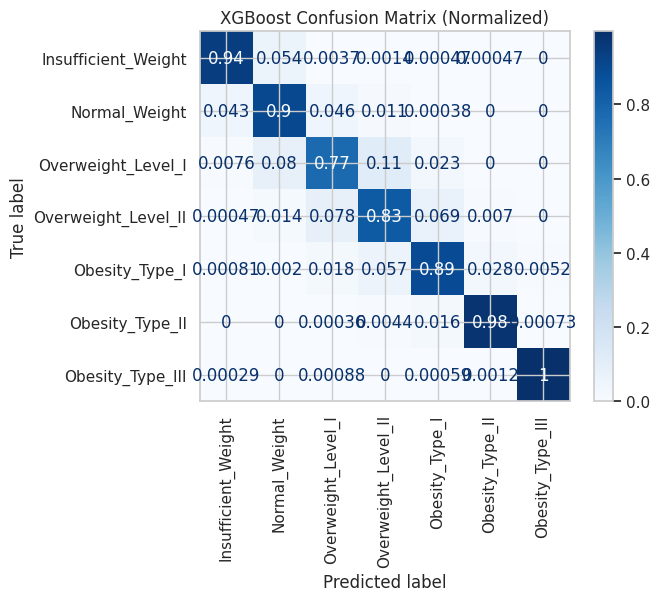

In [140]:
cm = confusion_matrix(
    y_true.map(target_mapping),
    y_pred.map(target_mapping),
    normalize='true'
)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_mapping.keys())
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("XGBoost Confusion Matrix (Normalized)")
plt.show()


In [141]:
# Compile average CV accuracies for all models
model_names = [ 'Decision Tree', 'KNN', 'Random Forest', 'XGBoost']
avg_val_acc = [
    np.mean(val_scores_dt),   
    np.mean(val_scores_knn), 
    np.mean(val_scores_rf),      
    np.mean(val_scores_xgb)  
]

# Create a DataFrame for comparison
accuracy_comparison = pd.DataFrame({
     'Model': model_names,
    'Average Validation Accuracy': avg_val_acc
}).sort_values(by='Average Validation Accuracy', ascending=False)

accuracy_comparison.reset_index(drop=True, inplace=True)
accuracy_comparison


Model  Average Validation Accuracy
0        XGBoost                     0.910962
1  Random Forest                     0.899287
2  Decision Tree                     0.838246
3            KNN                     0.764395

### Model Accuracy Comparison

After performing cross-validation on all models, the **average validation accuracy** for each model is summarized below:

| Model                 | Average Validation Accuracy |
|-----------------------|----------------------------|
| XGBoost               | 0.910692                  |
| Random Forest         | 0.900023                   |
| Decision Tree         | 0.838246                  |
| K-Nearest Neighbors   | 0.764395                   |

 From this comparison, **XGBoost** achieved the highest validation accuracy. For the final submission, we select **XGBoost** as the best-


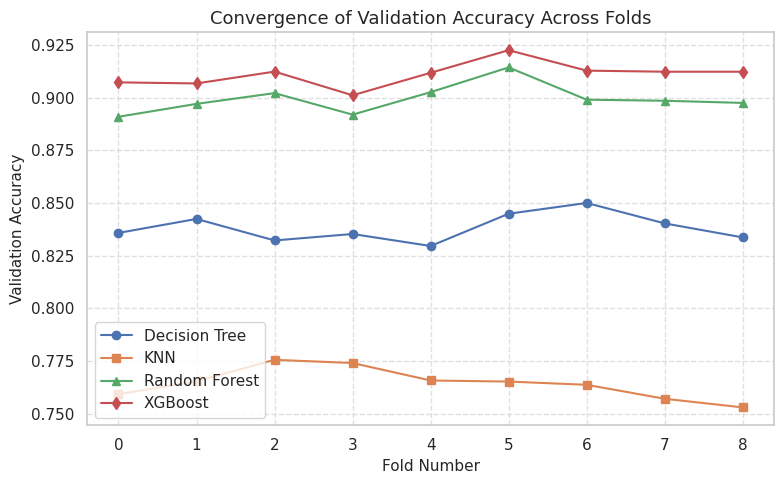

In [142]:
import matplotlib.pyplot as plt



# Plot convergence
plt.figure(figsize=(8, 5))
plt.plot(val_scores_dt, marker='o', label='Decision Tree')
plt.plot(val_scores_knn, marker='s', label='KNN')
plt.plot(val_scores_rf, marker='^', label='Random Forest')
plt.plot(val_scores_xgb, marker='d', label='XGBoost')

plt.title("Convergence of Validation Accuracy Across Folds", fontsize=13)
plt.xlabel("Fold Number", fontsize=11)
plt.ylabel("Validation Accuracy", fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Final_Submission

In [143]:
# Reload test_data to restore the 'id' column
test_data = pd.read_csv('../data/test.csv')

# Use only XGBoost predictions
final_pred = predict_list[[f"xgb_{k}" for k in target_mapping.keys()]].idxmax(axis=1)

# Remove the "xgb_" prefix
final_pred = final_pred.str.replace('xgb_', '', regex=False)

test_predictions = pd.DataFrame({
    'id': test_data['id'],       # restored ID column
    'WeightCategory': final_pred
})

test_predictions.to_csv("xgb_test_predictions.csv", index=False)
print(" Saved 'xgb_test_predictions.csv'")


 Saved 'xgb_test_predictions.csv'


In [144]:
print(test_data.columns)
train_data.shape

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS'],
      dtype='object')


(15533, 17)

In [145]:
test_predictions.head()

id       WeightCategory
0  15533     Obesity_Type_III
1  15534   Overweight_Level_I
2  15535  Overweight_Level_II
3  15536      Obesity_Type_II
4  15537        Normal_Weight

In [148]:
!pip freeze > requirements.txt
!head -n 10 requirements.txt

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.9.0
aiofiles==22.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.12.15
aiosignal==1.4.0
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.24
